In [1]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
torch.jit.script = lambda x: x

import re 
import h5py
from glob import glob
from functools import partial
from tqdm import tqdm

from tensorflow.python.summary.summary_iterator import summary_iterator

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy.spatial.distance import pdist, cdist
from scipy import stats

from transformercvn.network.trainers.neutrino_full_dense_trainer import NeutrinoFullDenseTrainer, sparse_to_dense
from transformercvn.network.trainers.neutrino_full_sparse_trainer import NeutrinoFullSparseTrainer
from transformercvn.network.trainers.neutrino_full_sdxl_trainer import NeutrinoFullSDXLTrainer
from transformercvn.dataset.minkowski_dataset import MinkowskiCollection
from transformercvn.options import Options

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmasher as cmr
import seaborn as sb

2025-04-22 16:40:20.202686: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 16:40:20.211518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 16:40:20.224209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 16:40:20.227981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 16:40:20.239517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

# Training History

In [10]:
tags = ['lr-AdamW/pg1',  # Learning Rate
        'val_epoch_accuracy', 'event_epoch_accuracy', 'prong_epoch_accuracy', # Validation accuracy, val = (event + prong)/2
        'train_loss', 'train_event_accuracy', 'train_prong_accuracy', # Possibly not helpful with small batch size
        'val_epoch_AUC', 'event_epoch_AUC', 'prong_epoch_AUC'] # ROC AUC, average='weighted'

In [11]:
# If training was stopped and restarted many times, this list can contain many tensorboards
tensorboards = ["./tutorial_dense/version_0/events.out.tfevents.1745284328.jupyter-ayankele.5847.0"]

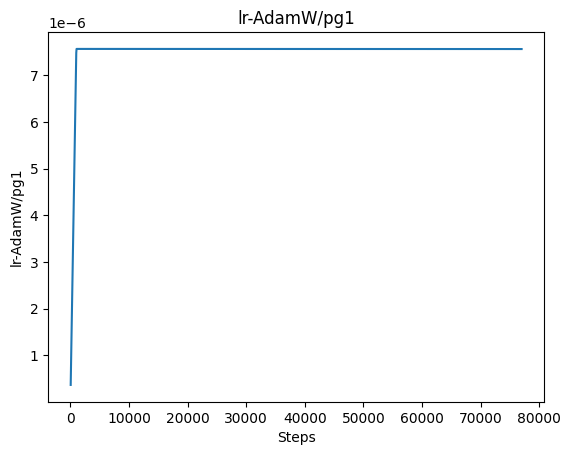

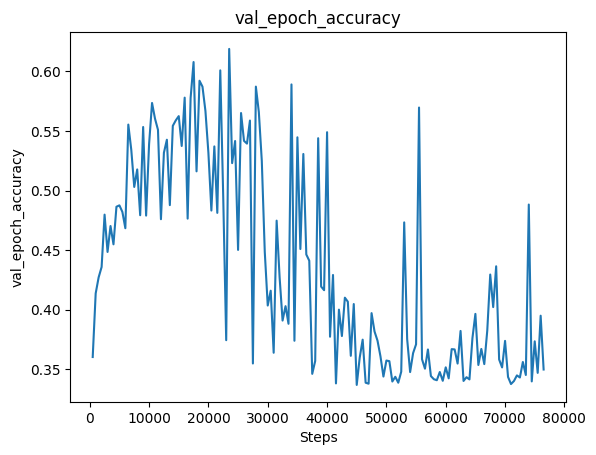

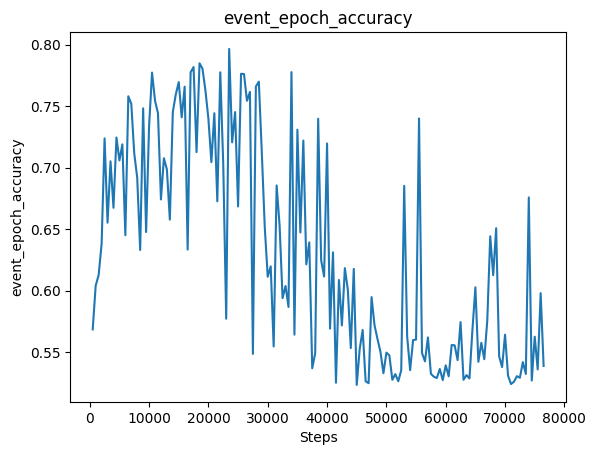

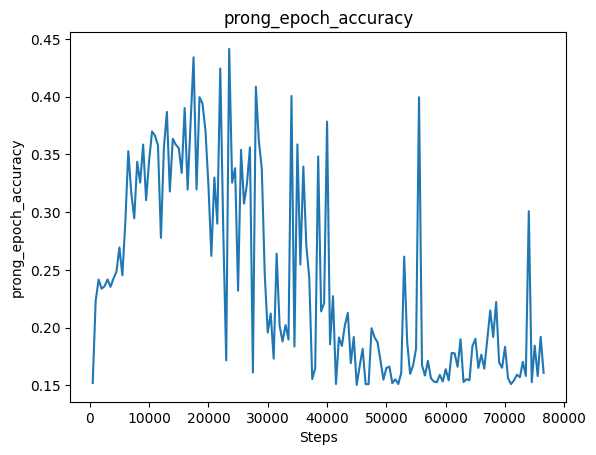

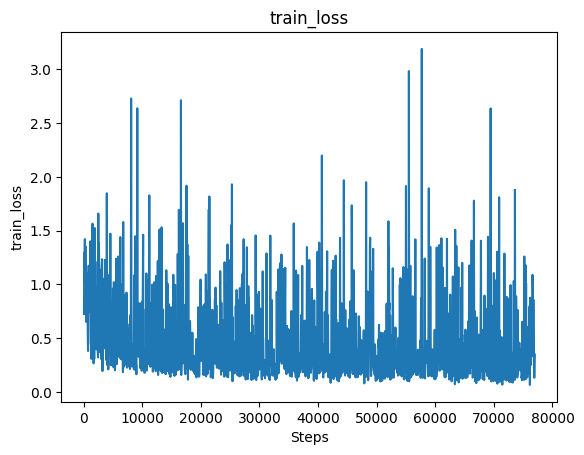

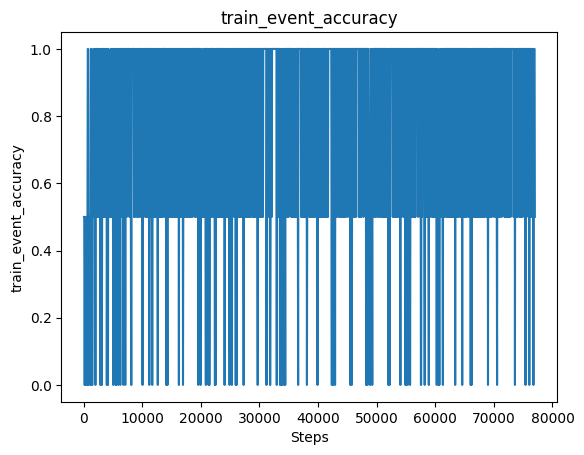

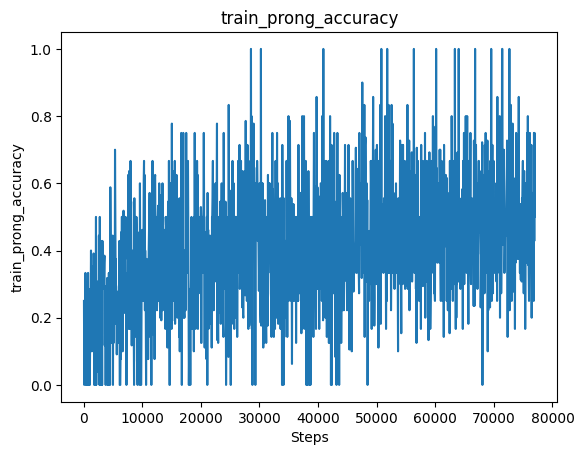

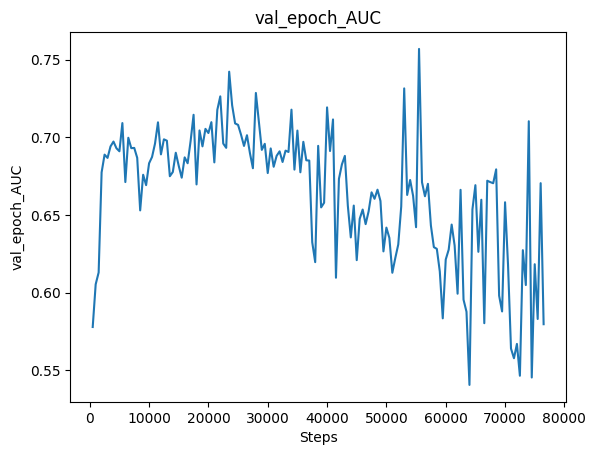

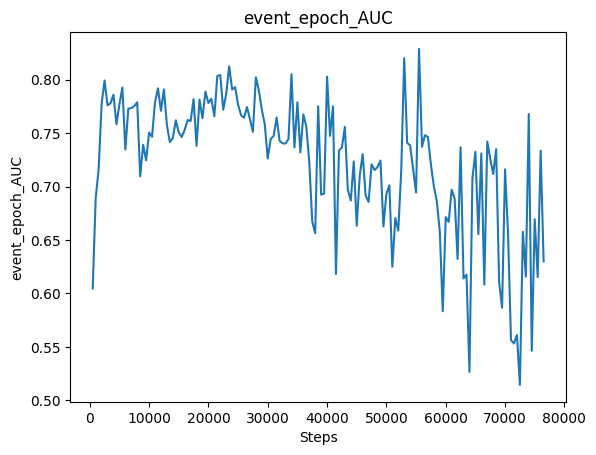

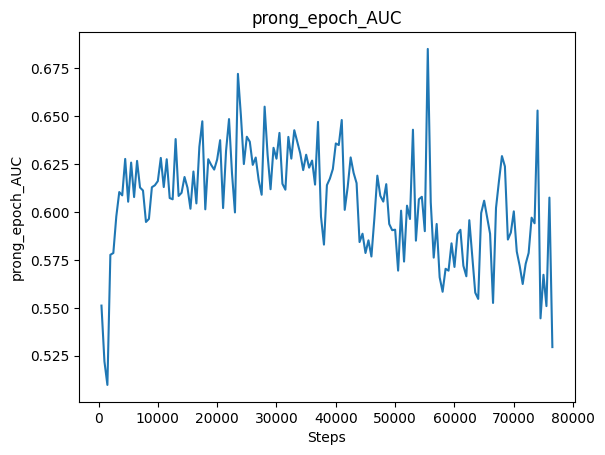

In [12]:
metrics = {tag:[] for tag in tags}

for tensorboard in tensorboards:
  for e in summary_iterator(tensorboard):
    for v in e.summary.value:
      #print(v)
      if v.tag in tags:
        metrics[v.tag].append([e.step, v.simple_value])
        last_step = e.step

for tag in tags:
    metric = np.array(metrics[tag])
    if metric.size==0:
        print("No values saved for metric", tag)
        continue
    plt.plot(metric[:,0], metric[:,1], label=tag)
    plt.xlabel('Steps')
    plt.ylabel(tag)
    plt.title(tag)
    #plt.legend()
    plt.show()

# Testing Dataset

In [13]:
CUDA = True
CUDA_DEVICE = 0
USE_TEX = False
TESTING_FILE = None

TESTING_SOURCE= "validation"
GRADIENT = False

NETWORK = NeutrinoFullDenseTrainer
#NETWORK = NeutrinoFullDenseTrainer
#NETWORK = NeutrinoFullSDXLTrainer

In [39]:
#TESTING_FILE = "/exp/dune/data/users/ayankele/fdhd_beam_2018prod_prong_pixels_minkowski_sparse.h5"
BASE_DIRECTORY = "./tutorial_dense/version_0/"
#CHECKPOINT_PATH = "./tutorial_dense/version_0/checkpoints/last.ckpt"
CHECKPOINT_PATH = "./tutorial_dense/version_0/checkpoints/epoch=0-step=28500.ckpt"

In [40]:
options = Options.load(f"{BASE_DIRECTORY}/options.json")
if TESTING_FILE:
    options.testing_file = TESTING_FILE
else:
    options.testing_file = options.training_file.replace("training", TESTING_SOURCE)
options.num_dataloader_workers = 0

if CHECKPOINT_PATH is None:
    checkpoints = glob(f"{BASE_DIRECTORY}/checkpoints/epoch*.ckpt")
    last_checkpoint = np.argmax([int(re.search("step=(.*).ckpt", s)[1]) for s in checkpoints])
    checkpoint_path = checkpoints[last_checkpoint]
else:
    checkpoint_path = CHECKPOINT_PATH
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint["state_dict"]
print(f"Loading from: {checkpoint_path}")

network = NETWORK(options)
network.load_state_dict(state_dict)

network = network.eval()

if not GRADIENT:
    for parameter in network.parameters():
        parameter.requires_grad_(False)

if CUDA:
    network = network.cuda(CUDA_DEVICE)

Loading from: ./tutorial_dense/version_0/checkpoints/epoch=0-step=28500.ckpt


In [41]:
#DATASET = network.training_dataset
DATASET = network.validation_dataset
#DATASET = network.testing_dataset

In [42]:
np.bincount(DATASET.event_targets)

array([4400, 2344, 1668,    5])

In [43]:
dataloader_options = network.dataloader_options
dataloader_options["pin_memory"] = False
dataloader_options["num_workers"] = 0
dataloader_options["batch_size"] = 16
dataloader_options["drop_last"] = False

test_dataloader = network.dataloader(DATASET, **dataloader_options)

In [44]:
batch = next(iter(network.dataloader(DATASET, **dataloader_options)))

if CUDA:
    batch = [b.cuda(CUDA_DEVICE) for b in batch]

(
        features,
        extra,
        event_coordinates,
        event_pixel_values,
        event_masks,
        prong_coordinates,
        prong_pixel_values,
        prong_masks,
        event_target,
        prong_target
) = batch

event_logits, prong_logits = network.forward(
        features,
        extra,
        event_coordinates,
        event_pixel_values,
        event_masks,
        prong_coordinates,
        prong_pixel_values,
        prong_masks,
    )

In [45]:
event_predictions = []
prong_predictions = []

event_targets = []
prong_targets = []

event_raws = []
prong_raws = []

total_attentions = []

for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
        
    (
            features,
            extra,
            event_coordinates,
            event_pixel_values,
            event_masks,
            prong_coordinates,
            prong_pixel_values,
            prong_masks,
            event_target,
            prong_target
    ) = batch
    
    event_logits, prong_logits = network.forward(
            features,
            extra,
            event_coordinates,
            event_pixel_values,
            event_masks,
            prong_coordinates,
            prong_pixel_values,
            prong_masks,
        )
    
    event_predictions.append(event_logits.argmax(-1).cpu())
    prong_predictions.append(prong_logits.argmax(-1).cpu())
    
    event_targets.append(event_target.cpu())
    prong_targets.append(prong_target.cpu())
    
    event_raws.append(event_logits.cpu())
    prong_raws.append(prong_logits.cpu())
            
event_targets = torch.cat(event_targets)
prong_targets = torch.cat(prong_targets)

event_predictions = torch.cat(event_predictions)
prong_predictions = torch.cat(prong_predictions)

event_raws = torch.cat(event_raws)
prong_raws = torch.cat(prong_raws)

prong_mask = prong_targets >= 0

100%|██████████| 527/527 [03:15<00:00,  2.70it/s]


In [46]:
event_probabilities = torch.softmax(event_raws, dim=1)
prong_probabilities = torch.softmax(prong_raws, dim=2)

In [47]:
flat_prong_probabilities = prong_probabilities[prong_mask]
flat_prong_predictions = prong_predictions[prong_mask]
flat_prong_targets = prong_targets[prong_mask]

In [48]:
event_probabilities # Score for [NumuCC, NueCC, NC, Other]

tensor([[0.4315, 0.3571, 0.2071, 0.0044],
        [0.6814, 0.1614, 0.1524, 0.0047],
        [0.0963, 0.6890, 0.2099, 0.0048],
        ...,
        [0.7301, 0.0963, 0.1687, 0.0050],
        [0.9606, 0.0088, 0.0191, 0.0115],
        [0.2540, 0.2101, 0.5336, 0.0023]])

In [49]:
event_targets

tensor([1, 1, 1,  ..., 2, 0, 2])

In [50]:
prong_probabilities # Score for [Electron, Muon, Proton, Neutron,
                    #            Pi +/-, Pi0, Photon, Other]

tensor([[[0.1198, 0.1815, 0.1445,  ..., 0.1441, 0.0910, 0.0932],
         [0.0797, 0.1332, 0.3067,  ..., 0.1669, 0.0497, 0.0557],
         [0.0460, 0.1212, 0.0913,  ..., 0.0680, 0.2804, 0.1580],
         ...,
         [0.0460, 0.1212, 0.0913,  ..., 0.0680, 0.2804, 0.1580],
         [0.0460, 0.1212, 0.0913,  ..., 0.0680, 0.2804, 0.1580],
         [0.0460, 0.1212, 0.0913,  ..., 0.0680, 0.2804, 0.1580]],

        [[0.0623, 0.2572, 0.1489,  ..., 0.0992, 0.1030, 0.0676],
         [0.0501, 0.2499, 0.2076,  ..., 0.0939, 0.0822, 0.0561],
         [0.0619, 0.2029, 0.2433,  ..., 0.1182, 0.0691, 0.0594],
         ...,
         [0.0460, 0.1212, 0.0913,  ..., 0.0680, 0.2804, 0.1580],
         [0.0460, 0.1212, 0.0913,  ..., 0.0680, 0.2804, 0.1580],
         [0.0460, 0.1212, 0.0913,  ..., 0.0680, 0.2804, 0.1580]],

        [[0.1953, 0.1239, 0.0883,  ..., 0.2376, 0.0853, 0.1157],
         [0.1315, 0.1344, 0.1894,  ..., 0.1994, 0.0664, 0.0770],
         [0.0460, 0.1212, 0.0913,  ..., 0.0680, 0.2804, 0.

In [51]:
prong_targets

tensor([[ 0,  2, -1,  ..., -1, -1, -1],
        [ 5,  0,  2,  ..., -1, -1, -1],
        [ 0,  5, -1,  ..., -1, -1, -1],
        ...,
        [ 5,  5,  5,  ..., -1, -1, -1],
        [ 1,  1,  2,  ..., -1, -1, -1],
        [ 4,  4, -1,  ..., -1, -1, -1]], dtype=torch.int8)

In [52]:
with h5py.File(BASE_DIRECTORY+"eval_predictions.h5", "w") as file:
    file.create_dataset("event_probabilities", data=event_probabilities.numpy())
    file.create_dataset("event_predictions", data=event_predictions.numpy())
    file.create_dataset("event_targets", data=event_predictions.numpy())
    
    file.create_dataset("prong_probabilities", data=prong_probabilities.numpy())
    file.create_dataset("prong_predictions", data=prong_predictions.numpy())
    file.create_dataset("prong_targets", data=prong_targets.numpy())

# Testing Metrics

In [53]:
event_classes = ["NumuCC", "NueCC", "NC", "Other"]
prong_classes = ["Electron", "Muon", "Proton", "Neutron", "Pi+/-", "Pi0", "Photon", "Other"]

In [54]:
print("Event Target Shape: ", event_targets.shape)
print("Event Probability Shape: ", event_probabilities.shape)
print("Prong Target Shape: ", flat_prong_targets.shape)
print("Prong Probability Shape: ", flat_prong_probabilities.shape)

print()

print(f"Event Accuracy: {accuracy_score(event_targets, event_predictions):.3f}")
print(f"Event Precision: {precision_score(event_targets, event_predictions, average='weighted'):.3f}")
print(f"Event Recall: {recall_score(event_targets, event_predictions, average='weighted'):.3f}")
print(f"Event ROC AUC: {roc_auc_score(event_targets, event_probabilities, multi_class='ovr', average='weighted'):.3f}")

print()

print(f"Prong Accuracy: {accuracy_score(flat_prong_targets, flat_prong_predictions):.3f}")
print(f"Prong Precision: {precision_score(flat_prong_targets, flat_prong_predictions, average='weighted'):.3f}")
print(f"Prong Recall: {recall_score(flat_prong_targets, flat_prong_predictions, average='weighted'):.3f}")
print(f"Prong ROC AUC: {roc_auc_score(flat_prong_targets, flat_prong_probabilities, multi_class='ovr', average='weighted'):.3f}")

Event Target Shape:  torch.Size([8417])
Event Probability Shape:  torch.Size([8417, 4])
Prong Target Shape:  torch.Size([47224])
Prong Probability Shape:  torch.Size([47224, 8])

Event Accuracy: 0.770
Event Precision: 0.765
Event Recall: 0.770
Event ROC AUC: 0.917

Prong Accuracy: 0.362
Prong Precision: 0.423
Prong Recall: 0.362
Prong ROC AUC: 0.698


/exp/dune/data/users/ayankele/transformercvn_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/exp/dune/data/users/ayankele/transformercvn_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
# Check event classification performance
event_aucs = roc_auc_score(
    event_targets.numpy(),
    event_probabilities.numpy(),
    average=None,
    multi_class="ovr"
)

print(f"NumuCC ROC AUC: {event_aucs[0]:.3f}")
print(f"NueCC ROC AUC: {event_aucs[1]:.3f}")
print(f"NC ROC AUC: {event_aucs[2]:.3f}")
print(f"Other AUC: {event_aucs[3]:.3f}")

NumuCC ROC AUC: 0.944
NueCC ROC AUC: 0.899
NC ROC AUC: 0.874
Other AUC: 0.444


In [56]:
# Check prong classification performance
prong_aucs = roc_auc_score(
    flat_prong_targets.numpy(),
    flat_prong_probabilities.numpy(),
    average=None,
    multi_class="ovr"
)

print(f"Electron ROC AUC: {prong_aucs[0]:.3f}")
print(f"Muon ROC AUC: {prong_aucs[1]:.3f}")
print(f"Proton ROC AUC: {prong_aucs[2]:.3f}")
print(f"Neutron AUC: {prong_aucs[3]:.3f}")
print(f"Charged Pion ROC AUC: {prong_aucs[4]:.3f}")
print(f"Neutral Pion ROC AUC: {prong_aucs[5]:.3f}")
print(f"Photon ROC AUC: {prong_aucs[6]:.3f}")
print(f"Other AUC: {prong_aucs[7]:.3f}")

Electron ROC AUC: 0.765
Muon ROC AUC: 0.884
Proton ROC AUC: 0.717
Neutron AUC: 0.575
Charged Pion ROC AUC: 0.521
Neutral Pion ROC AUC: 0.648
Photon ROC AUC: 0.465
Other AUC: 0.465


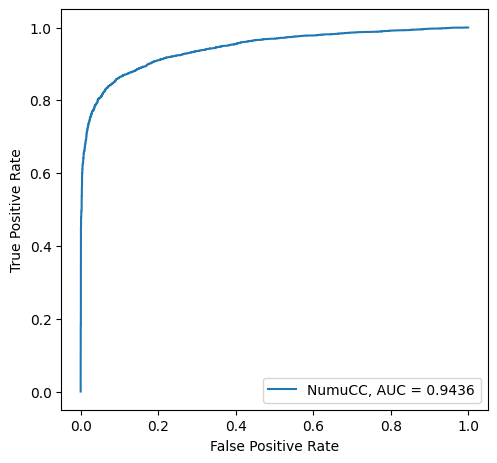

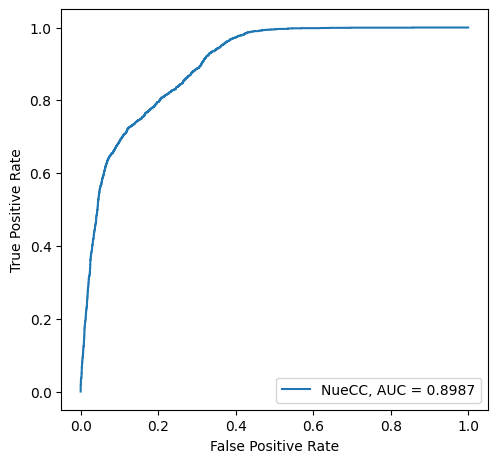

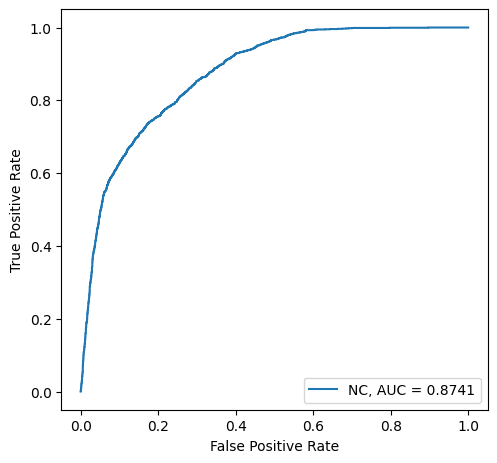

In [57]:
for i in range(3):
    plt.figure(figsize=[5.5,5.2])
    fpr,tpr,thr = roc_curve(event_targets, event_probabilities[:,i], pos_label=i, drop_intermediate=False)
    plt.plot(fpr,tpr, label = "%s, AUC = %.4f" % (event_classes[i],event_aucs[i]))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')

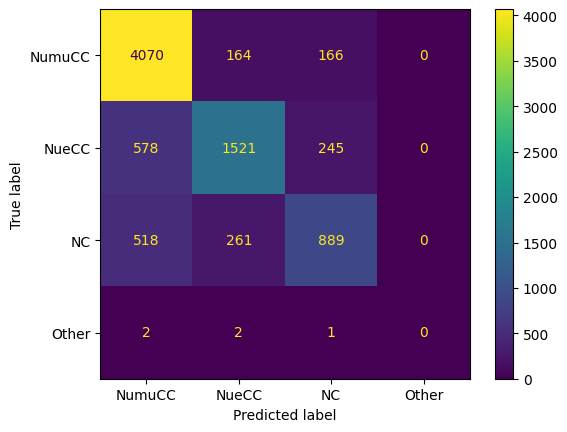

In [58]:
err_mat = confusion_matrix(event_targets, event_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=err_mat, display_labels=event_classes)
disp.plot()